In [65]:
import sys
#sys.path.insert(1, r"folder where you put files from zenodo")

# from bayes_multi_order_model_1 import BayesMultiOrderNetworkModel
from bayes_multi_order_model_1 import opt_order_bayes_factors
from bayes_multi_order_model_1 import ML_loglh_and_DoF_of_BMONs
from bayes_multi_order_model_1 import AIC, BIC, p_value

from paths import Paths
from constraint import NetworkConstraint

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk", font_scale=1.4)


# for using LaTeX fonts
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})


In [6]:
# paths = Paths()

# file1 = r"MSNBC.ngram"
# paths.update_from_ngram(file1, splitter = ",", last_entry_frequency = False)
# paths.print_stats()

In [7]:
import pathpy as pp


In [8]:
# load the Polity5 data from the excel data frame
timeSeries = pd.read_excel('./../../data/polity5/p5v2018.xls')
# do some cleaning
timeSeries = timeSeries.dropna(subset=['year', 'country', 'polity2'])

timeSeries = timeSeries[timeSeries["polity2"] != -66]
timeSeries = timeSeries[timeSeries["polity2"] != -88]

In [13]:
def pathFromTimeSeries(timeSeriesIn):

    #paths = pp.Paths()
    paths = Paths()
    

     # split the timeseries into one for each country 
    uniqueCountries = timeSeriesIn['country'].unique()
    countryTimeseries =[]


    for country in uniqueCountries:
        sortedPolity2Country = timeSeriesIn[timeSeriesIn['country'] == country].sort_values(by='year')["polity2"].tolist()
        
        #print(tuple(sortedPolity2Country))

        paths.add_path(tuple(sortedPolity2Country))
        
        #break
        #T=len(sortedPolity2Country)# number of data points
    
    return(paths)

In [14]:
paths = pathFromTimeSeries(timeSeries)

# The graph constraint:
We assume that all edges were traversed. The assumption is not good, but it is the best we can do with this data.

In [15]:
edges = set()
nodes = set()
for length in paths.lengths():
    for path in paths.paths_of_length(length):
        for en,node in enumerate(path[1:]):
            edge = (path[en],node)
            edges.add(edge)
            # edges.add((edge[1], edge[0]))
            nodes.update(set(edge))
            

In [16]:
len(edges)

326

In [17]:
len(nodes)

21

In [18]:
topo_const = NetworkConstraint(nodes,edges)

# The Order detection
## Optimal order using MLE methods

In [49]:
max_order = 7

In [50]:
ml_log_lh, dof, n_obs = ML_loglh_and_DoF_of_BMONs(
    paths = paths,
    max_order = max_order,
    nodes = nodes,
    constraint = topo_const
)

### AIC

In [51]:
for i in range(max_order+1):
    print(i, AIC(ml_log_lh[i], dof[i]))
print("MIN:", min(range(max_order +1), key = lambda i: AIC(ml_log_lh[i], dof[i])))

0 99119.29050402016
1 17571.019041917436
2 25033.327321559384
3 178096.90290512767
4 2635243.3310316424
5 41756432.69420672
6 664360246.4035667
7 10572693457.700304
MIN: 1


### BIC

In [52]:
for i in range(max_order+1):
    print(i, BIC(ml_log_lh[i], dof[i], n_obs[i]))
print("MIN:", min(range(max_order + 1), key = lambda i: BIC(ml_log_lh[i], dof[i], n_obs[i])))

0 99274.43660486733
1 20092.1431806838
2 65200.65283088935
3 817376.4114458542
4 12809391.060471635
5 203672155.23381755
6 3241143607.374814
7 51580461980.437515
MIN: 1


### Likelihood ratio test

In [53]:
for i in range(1, max_order+1):
    print(f"reject {i-1} for {i}? p-value", p_value( ml_log_lh[i-1], ml_log_lh[i], dof[i-1], dof[i]))

reject 0 for 1? p-value 0.0
reject 1 for 2? p-value 1.0
reject 2 for 3? p-value 1.0
reject 3 for 4? p-value 1.0
reject 4 for 5? p-value 1.0
reject 5 for 6? p-value 1.0
reject 6 for 7? p-value 1.0


## Bayes factor method

In [54]:
_, bayes_log_lh = opt_order_bayes_factors(
    paths = paths, 
    max_order = max_order, 
    nodes = nodes,
    constraint = topo_const
)

In [55]:
for i in range(1, max_order+1):
    print()
    passed = True
    for j in range(i):
#         print(i, j)
#         print(2*(bayes_log_lh[i] - bayes_log_lh[j]))
        passed = passed and ((bayes_log_lh[i] - bayes_log_lh[j]) > np.log(150))
#         print(2*(bayes_log_lh[i] - bayes_log_lh[j]) > 10)
#         print()
    if passed:
        print(f"Order {i} is better than all lower.")
    else:
        print(f"Order {i} is NOT better than all lower.")
        


Order 1 is better than all lower.

Order 2 is NOT better than all lower.

Order 3 is NOT better than all lower.

Order 4 is NOT better than all lower.

Order 5 is NOT better than all lower.

Order 6 is NOT better than all lower.

Order 7 is NOT better than all lower.


In [44]:
print(n_obs)

defaultdict(<class 'int'>, {0: 17280, 1: 17280, 2: 17280, 3: 17280, 4: 17280, 5: 17280, 6: 17280})


## Illustration

In [57]:
bic=[]
aic=[]
order = range(max_order+1)

for i in range(max_order+1):
    #print(i, BIC(ml_log_lh[i], dof[i], n_obs[i]))
    bic.append(BIC(ml_log_lh[i], dof[i], n_obs[i]))

for i in range(max_order+1):
    #print(i, AIC(ml_log_lh[i], dof[i]))
    aic.append(AIC(ml_log_lh[i], dof[i]))

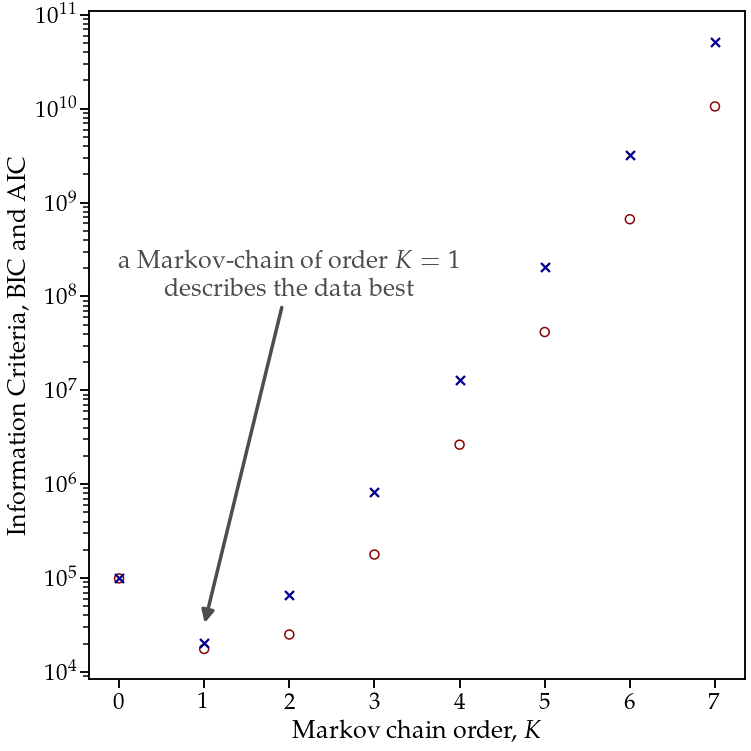

In [99]:
from turtle import fillcolor


fig = plt.figure(figsize=(11,11))
ax = fig.add_subplot(1, 1, 1)

plt.scatter(order,aic,edgecolor='#8B0000',color='none')
plt.scatter(order,bic,color='#00008C',marker='x')
plt.yscale('log')

plt.xlabel(r'Markov chain order, $K$')
plt.ylabel(r'Information Criteria, BIC and AIC ')

#plt.title(r'Model selection for regime transitions')


darkgray = 0.3*np.array([1,1,1])


ax.annotate('a Markov-chain of order $K=1$\n describes the data best', xy=(1, 10**4.5),ha='center',
             xycoords='data',
             xytext=(2, 10**8),
             textcoords='data',
             color=darkgray,
             arrowprops=dict(arrowstyle= '-|>',
                             color=darkgray,
                             lw=3.5,
                             ls='-')
           )


fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.savefig('./../fig/markovChainOrder.pdf',bbox_inches='tight')
